In [1]:

import numpy as np # linear algebra
 # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk():
#     for filename in filenames:
#         print(os.path.join(dirname, filename)

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense
from sklearn.metrics import mean_squared_error, r2_score 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
%matplotlib inline

In [ ]:
def plot_create(x, y):
    plt.plot(x, y, '-', label=y.name)
    
def process_visualisation(df, breath_id):
    plt.figure(figsize=(14, 6))
    plt.title('Breath Id - {}'.format(breath_id))
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['pressure'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['u_in'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['u_out'])
    plt.grid()
    plt.legend()
    plt.ylabel('Value')
    plt.show()

def process_visualisation_with_preds(df, df_preds, breath_id):
    plt.figure(figsize=(14, 6))
    plt.title('Breath Id - {}'.format(breath_id))
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['pressure'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['u_in'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['u_out'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df_preds)
    plt.grid()
    plt.legend()
    plt.ylabel('Value')
    plt.show()

READING  THE DATA  FILES 


In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./sample_submission.csv')

In [ ]:
def df_overview(df):
    print('Dataframe overview:\n')
    display(df.head())
    print('--------------------------------------------\nSample:\n')
    display(df.sample(10, random_state=555))
    print('--------------------------------------------\nInfo:\n')
    print(df.info())
    print('--------------------------------------------\nNaN\'s:\n')
    print(df.isna().sum())
    print('--------------------------------------------\nDescribe:\n')
    display(df.describe())
    print('--------------------------------------------\nFeature correlation:\n')
    display(df.corr())

In [ ]:
df_train = train
df_test= test


In [ ]:
sample.head()

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
print(train.shape)
print(test.shape)

(6036000, 8)
(4024000, 7)


In [ ]:
df_train = df_train.drop('id', axis=1)
df_overview(df_train)

Dataframe overview:



,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,20,50,0.000000,0.083334,0,5.837492
1,1,20,50,0.033652,18.383041,0,5.907794
2,1,20,50,0.067514,22.509278,0,7.876254
3,1,20,50,0.101542,22.808822,0,11.742872
4,1,20,50,0.135756,25.355850,0,12.234987


--------------------------------------------
Sample:



,breath_id,R,C,time_step,u_in,u_out,pressure
4518483,94149,50,10,0.100144,3.023038,0,9.211995
5495313,114554,50,10,1.137127,0.000000,1,6.329607
3274892,68163,20,10,0.404521,5.433753,0,29.388710
1426430,29628,50,20,0.964605,9.581468,0,24.959675
4593076,95716,20,50,1.156033,0.000000,1,6.610815
5828127,121376,50,10,1.589455,4.308748,1,7.243535
4733541,98634,5,50,0.714422,0.000000,0,10.547735
4216033,87877,50,50,1.047389,0.000000,1,8.227765
2733013,56897,50,20,1.693041,3.207199,1,6.892024
453237,9391,5,50,1.190098,0.000000,1,8.930786


--------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   breath_id  int64  
 1   R          int64  
 2   C          int64  
 3   time_step  float64
 4   u_in       float64
 5   u_out      int64  
 6   pressure   float64
dtypes: float64(3), int64(4)
memory usage: 322.4 MB
None
--------------------------------------------
NaN's:

breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64
--------------------------------------------
Describe:



,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


--------------------------------------------
Feature correlation:



,breath_id,R,C,time_step,u_in,u_out,pressure
breath_id,1.000000,0.001860,0.007222,-0.000213,-0.002378,-0.000100,-0.002394
R,0.001860,1.000000,-0.096070,-0.014535,-0.148120,-0.007594,0.015976
C,0.007222,-0.096070,1.000000,0.004936,0.151002,0.003720,-0.036727
time_step,-0.000213,-0.014535,0.004936,1.000000,-0.352276,0.839191,-0.524829
u_in,-0.002378,-0.148120,0.151002,-0.352276,1.000000,-0.416985,0.308136
u_out,-0.000100,-0.007594,0.003720,0.839191,-0.416985,1.000000,-0.614910
pressure,-0.002394,0.015976,-0.036727,-0.524829,0.308136,-0.614910,1.000000


In [ ]:
def add_features(df):
    df['u_in_cumsum'] = df['u_in'].groupby(df['breath_id']).cumsum()
    df['u_in_lag_1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_in_lag_2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_in_lag_3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_in_rolling_mean_3'] = df.groupby('breath_id')['u_in'].shift().rolling(3).mean()
    df['u_in_rolling_mean_5'] = df.groupby('breath_id')['u_in'].shift().rolling(5).mean()
    df['u_in_begin'] = df.groupby('breath_id')['u_in'].transform('first')
    df['u_in_end'] = df.groupby('breath_id')['u_in'].transform('last')
    df['u_in_min'] = df.groupby('breath_id')['u_in'].transform('min')
    df['u_in_max'] = df.groupby('breath_id')['u_in'].transform('max')
    df['u_in_median'] = df.groupby('breath_id')['u_in'].transform('median')
    df = df.fillna(0)
    df = df.drop(['breath_id', 'u_in', 'u_out'], axis=1)
    return df

In [ ]:
X = df_train.copy()
X = X.drop('pressure', axis=1)
X = add_features(X)
y = df_train['pressure']

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=555)


In [ ]:
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor(max_depth=15, random_state=555)

In [ ]:
def train_and_score(model):
    model.fit(X_train, y_train)
    return mean_absolute_error(y_valid, model.predict(X_valid))

In [ ]:
display(
    pd.DataFrame(data=([train_and_score(linear_model)],
                       [train_and_score(tree_model)],
                      ),
                 columns=['Result MAE'],
                 index=['Linear', 'Tree'])
)

,Result MAE
Linear,3.943032
Tree,0.528356


In [ ]:
linear_model.fit(X, y)
tree_model.fit(X, y)

DecisionTreeRegressor(max_depth=15, random_state=555)

Pressure predictions by Linear Model where pressure is normal:


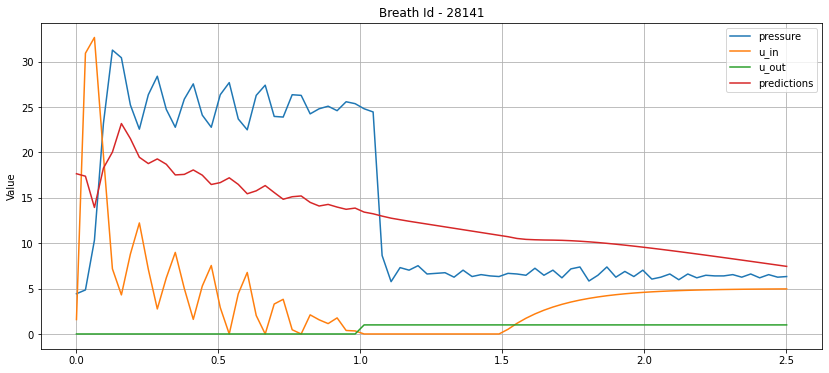

Pressure predictions by Tree Model where pressure in normal:


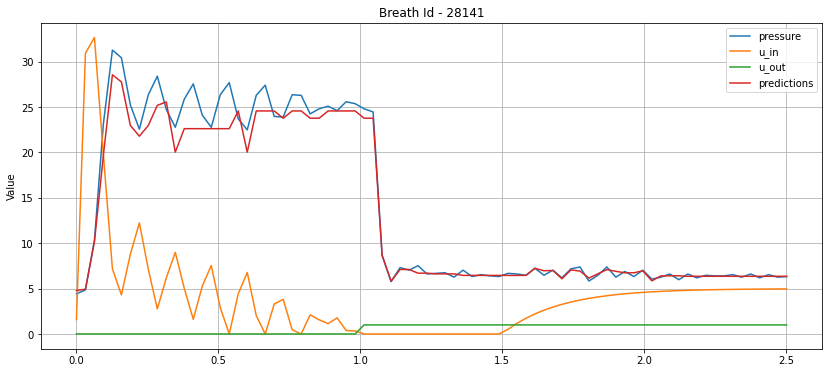

In [ ]:
X_df_vis = df_train[df_train['breath_id'] == 28141].reset_index()
X_df_vis = add_features(X_df_vis)
X_df_vis = X_df_vis.drop(['index', 'pressure'], axis=1)

print('Pressure predictions by Linear Model where pressure is normal:')
process_visualisation_with_preds(df_train, pd.Series(linear_model.predict(X_df_vis), name='predictions'), 28141)
print('Pressure predictions by Tree Model where pressure in normal:')
process_visualisation_with_preds(df_train, pd.Series(tree_model.predict(X_df_vis), name='predictions'), 28141)

Pressure predictions by Linear Model where pressure is below 0:


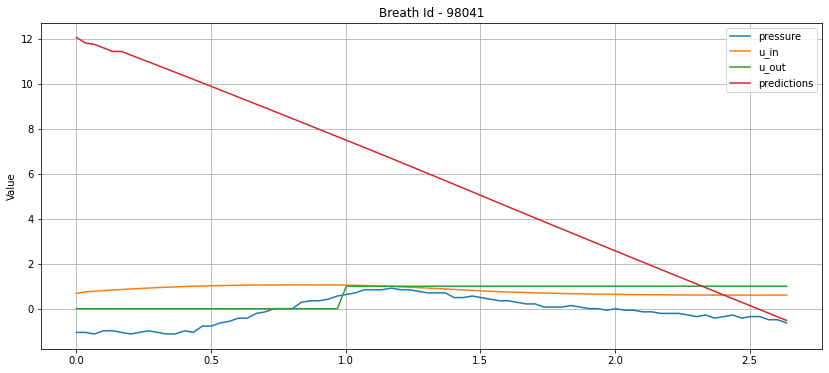

Pressure predictions by Tree Model where pressure in below 0:


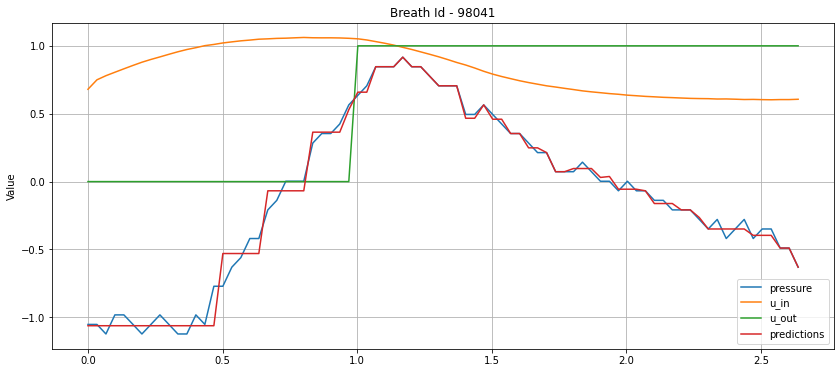

In [ ]:
X_df_vis = df_train[df_train['breath_id'] == 98041].reset_index()
X_df_vis = add_features(X_df_vis)
X_df_vis = X_df_vis.drop(['index', 'pressure'], axis=1)

print('Pressure predictions by Linear Model where pressure is below 0:')
process_visualisation_with_preds(df_train, pd.Series(linear_model.predict(X_df_vis), name='predictions'), 98041)
print('Pressure predictions by Tree Model where pressure in below 0:')
process_visualisation_with_preds(df_train, pd.Series(tree_model.predict(X_df_vis), name='predictions'), 98041)

Pressure predictions by Linear Model where pressure is high:


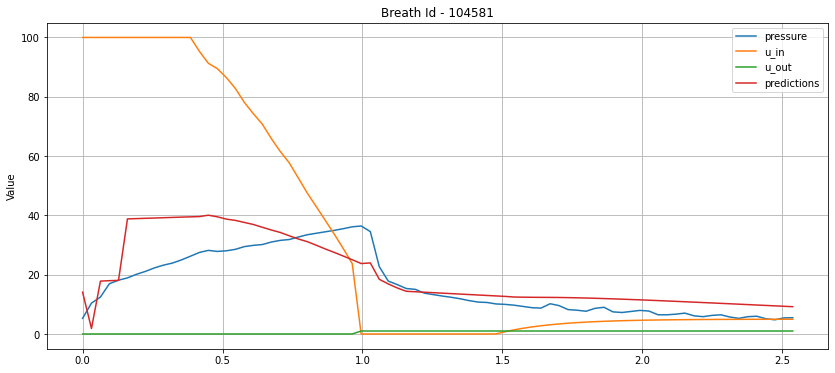

Pressure predictions by Tree Model where pressure in high:


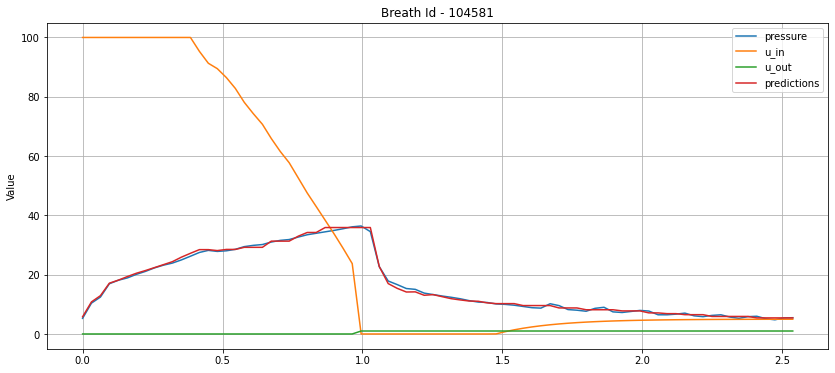

In [ ]:
X_df_vis = df_train[df_train['breath_id'] == 104581].reset_index()
X_df_vis = add_features(X_df_vis)
X_df_vis = X_df_vis.drop(['index', 'pressure'], axis=1)

print('Pressure predictions by Linear Model where pressure is high:')
process_visualisation_with_preds(df_train, pd.Series(linear_model.predict(X_df_vis), name='predictions'), 104581)
print('Pressure predictions by Tree Model where pressure in high:')
process_visualisation_with_preds(df_train, pd.Series(tree_model.predict(X_df_vis), name='predictions'), 104581)

In [ ]:
df_test_featured = df_test.copy()
df_test_featured = add_features(df_test_featured)
df_test_featured = df_test_featured.drop('id', axis=1)

In [ ]:
preds = tree_model.predict(df_test_featured)

In [ ]:
output = pd.DataFrame({'id': df_test['id'].values,
                       'pressure': preds})
# display(output)
output.to_csv('submission.csv', index=False)